# Capstone Project by Marshal Pfluger
### Machine Learning 2
### Dr. Sajjad Mohsin

For the capstone project I chose to look at a problem that is near to my heart. I have been an avid scuba diver for quite some time and over the past decade I have witnessed the dramatic decrease in coral life around the Caribbean. One of the main reasons for this is rising ocean temperatures which leads to coral bleaching. Coral bleaching occurs when the organism that lives in the coral leaves the coral because the temperatures are too high, they will never return, and the coral will bleach and die. For this project I found a dataset that has pictures of healthy coral, and pictures of bleached coral. My goal was to try and use a convolutional neural network to classify the images as healthy or bleached. I also wanted to use a pretrained model to see the difference in accuracy. I started off by training my own CNN to see what kind of accuracy I could get. I then looked to transfer learning to use a pretrained model to run image classification. I used the VGG19 model which is a pretrained model for image classification. One of my main concerns with this process is with the dataset images. When taking underwater photos there are many variable that affect how the picture looks in the end. The deeper the picture is taken, the less color that will be in the image. If there is cloudy water it may look blurry, or the color may change due to algae in the water. Coral reefs are also the main habitat of countless fish species and are basically fish cities. I know there will be many fish in the pictures that may confuse the mode. I am curious how the model does with pictures that have so much variety.

### First we will import the required dependencies for out notebook

In [10]:
from google.colab import files
import zipfile
import io
from pathlib import Path
import seaborn as sns

# We will use pandas as well
import pandas as pd

# We will also use numpy and need OS
import numpy as np
import os

import matplotlib as plt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras import layers,models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Import series of helper functions for our notebook
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2023-12-01 00:49:39--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.2’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-12-01 00:49:39 (92.5 MB/s) - ‘helper_functions.py.2’ saved [10246/10246]



In [2]:
uploaded = files.upload()

Saving Coral.zip to Coral.zip


In [3]:
# Specify the name of your uploaded zip file
zip_file_name = 'Coral.zip'

# Unzip the file
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall('images')

In [4]:
dataset = "/content/images/"

In [5]:
def convert_path_to_df(dataset):
    image_dir = Path(dataset)

    # Get filepaths and labels
    filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.jpeg')) + list(image_dir.glob(r'**/*.PNG'))

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df

image_df = convert_path_to_df(dataset)

In [6]:
# Check for corrupted images within the dataset
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path(dataset).rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

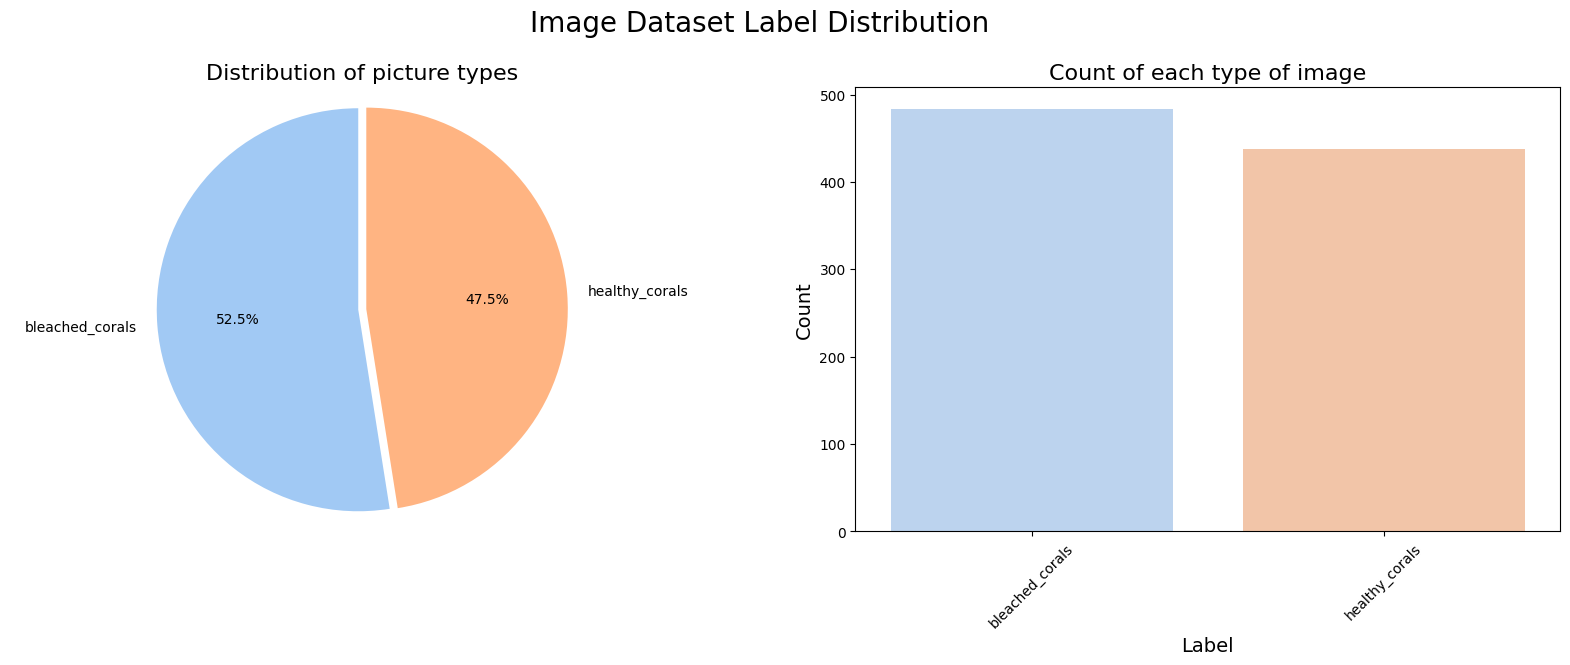

In [11]:
# Get the value counts for each label
label_counts = image_df['Label'].value_counts()

# Create the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# Define the color palette for the pie chart
colors = sns.color_palette('pastel', len(label_counts))

# Plot the pie chart with percentages, colors, and separation
explode = [0.02] * len(label_counts)  # Define separation values for each pie slice
axes[0].pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%', startangle=90, colors=colors, explode=explode)
axes[0].axis('equal')  # Equal aspect ratio ensures the pie chart is circular
axes[0].set_title('Distribution of picture types', fontsize=16)

# Plot the bar chart
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='pastel', ax=axes[1])
axes[1].set_title('Count of each type of image', fontsize=16)
axes[1].set_xlabel('Label', fontsize=14)
axes[1].set_ylabel('Count', fontsize=14)
axes[1].set_xticklabels(label_counts.index, rotation=45)

# Add a super-title to the figure
fig.suptitle('Image Dataset Label Distribution', fontsize=20)

# Adjust the spacing between the plots and the title
fig.subplots_adjust(top=0.85)

# Display the plot
plt.show()

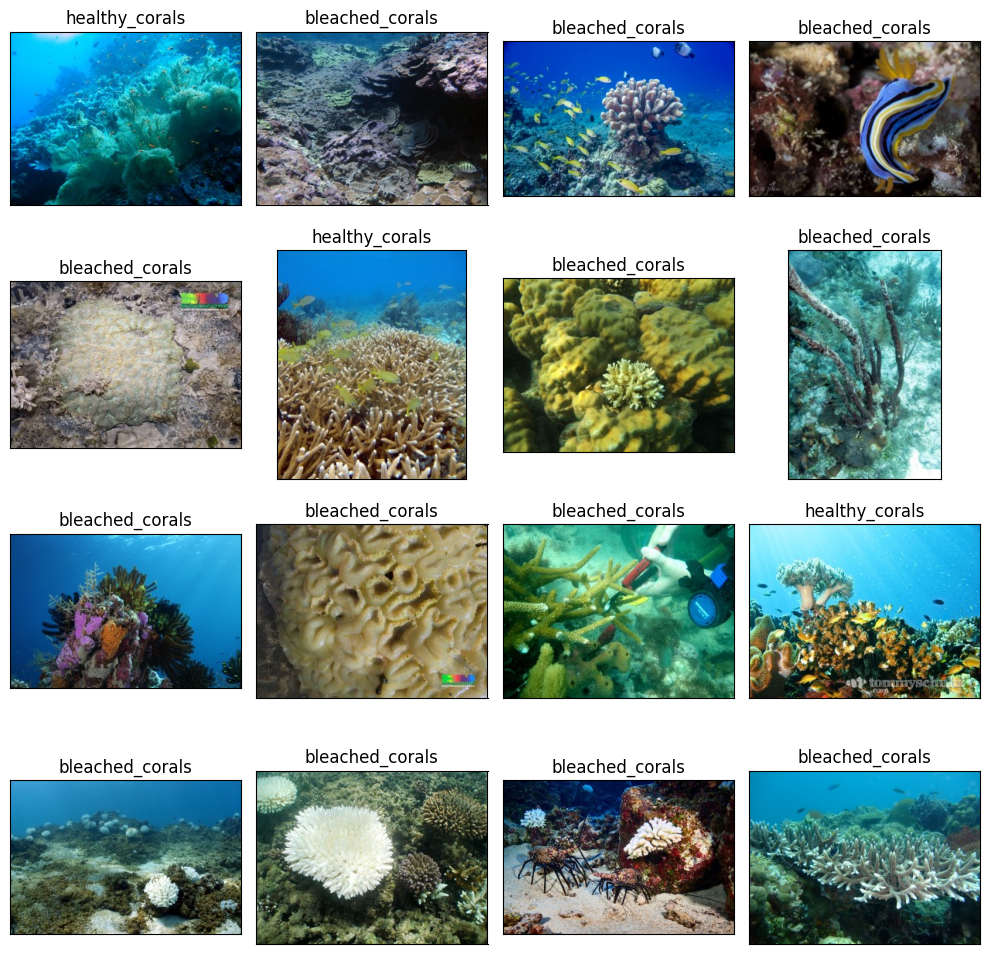

In [12]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [13]:
# declare batch and target size
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

### Splitting up dataset into training, validation, and test sets

In [14]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [15]:
# Use keras image data generator to pre proccess the images
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input
)

In [16]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 590 validated image filenames belonging to 2 classes.
Found 147 validated image filenames belonging to 2 classes.
Found 185 validated image filenames belonging to 2 classes.


In [17]:
# Data Augmentation to increase efficiency of training. This is only used in the VGG19 model
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
])

### We are going to now start building our first model.

In [35]:
# We will reset the model and set the seeds
keras.backend.clear_session()
np.random.seed(12)
tf.random.set_seed(12)

In [36]:
# Declare optimizer to manipulate hyperparameter
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-7)

In [37]:
# Define the model (9 total layers)
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [38]:
# Train the model
history = model.fit(train_images, epochs=30,validation_data=val_images)

Epoch 1/30
19/19 [==============================] - 35s 111ms/step - loss: 2.2969 - accuracy: 0.5475 - val_loss: 1.9352 - val_accuracy: 0.5170
Epoch 2/30
19/19 [==============================] - 2s 100ms/step - loss: 1.7898 - accuracy: 0.5678 - val_loss: 1.5624 - val_accuracy: 0.5442
Epoch 3/30
19/19 [==============================] - 2s 112ms/step - loss: 1.6022 - accuracy: 0.5610 - val_loss: 1.4459 - val_accuracy: 0.5578
Epoch 4/30
19/19 [==============================] - 3s 153ms/step - loss: 1.4742 - accuracy: 0.5644 - val_loss: 1.3784 - val_accuracy: 0.5578
Epoch 5/30
19/19 [==============================] - 2s 100ms/step - loss: 1.3700 - accuracy: 0.5661 - val_loss: 1.3157 - val_accuracy: 0.5578
Epoch 6/30
19/19 [==============================] - 2s 103ms/step - loss: 1.2815 - accuracy: 0.5797 - val_loss: 1.2562 - val_accuracy: 0.5510
Epoch 7/30
19/19 [==============================] - 2s 101ms/step - loss: 1.2124 - accuracy: 0.5915 - val_loss: 1.2053 - val_accuracy: 0.5646
Epoch

In [39]:
# Evaluate the model with the test dataset.
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.85971
Test Accuracy: 68.11%


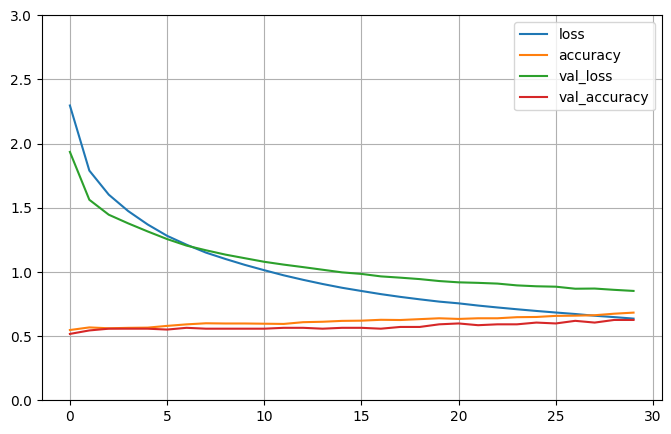

In [41]:
# I want to visualize this learning run
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 3) # set the vertical range to [0-15]
plt.show()

In [42]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

6/6 [==============================] - 2s 306ms/step
The first 5 predictions: ['healthy_corals', 'bleached_corals', 'bleached_corals', 'healthy_corals', 'bleached_corals']


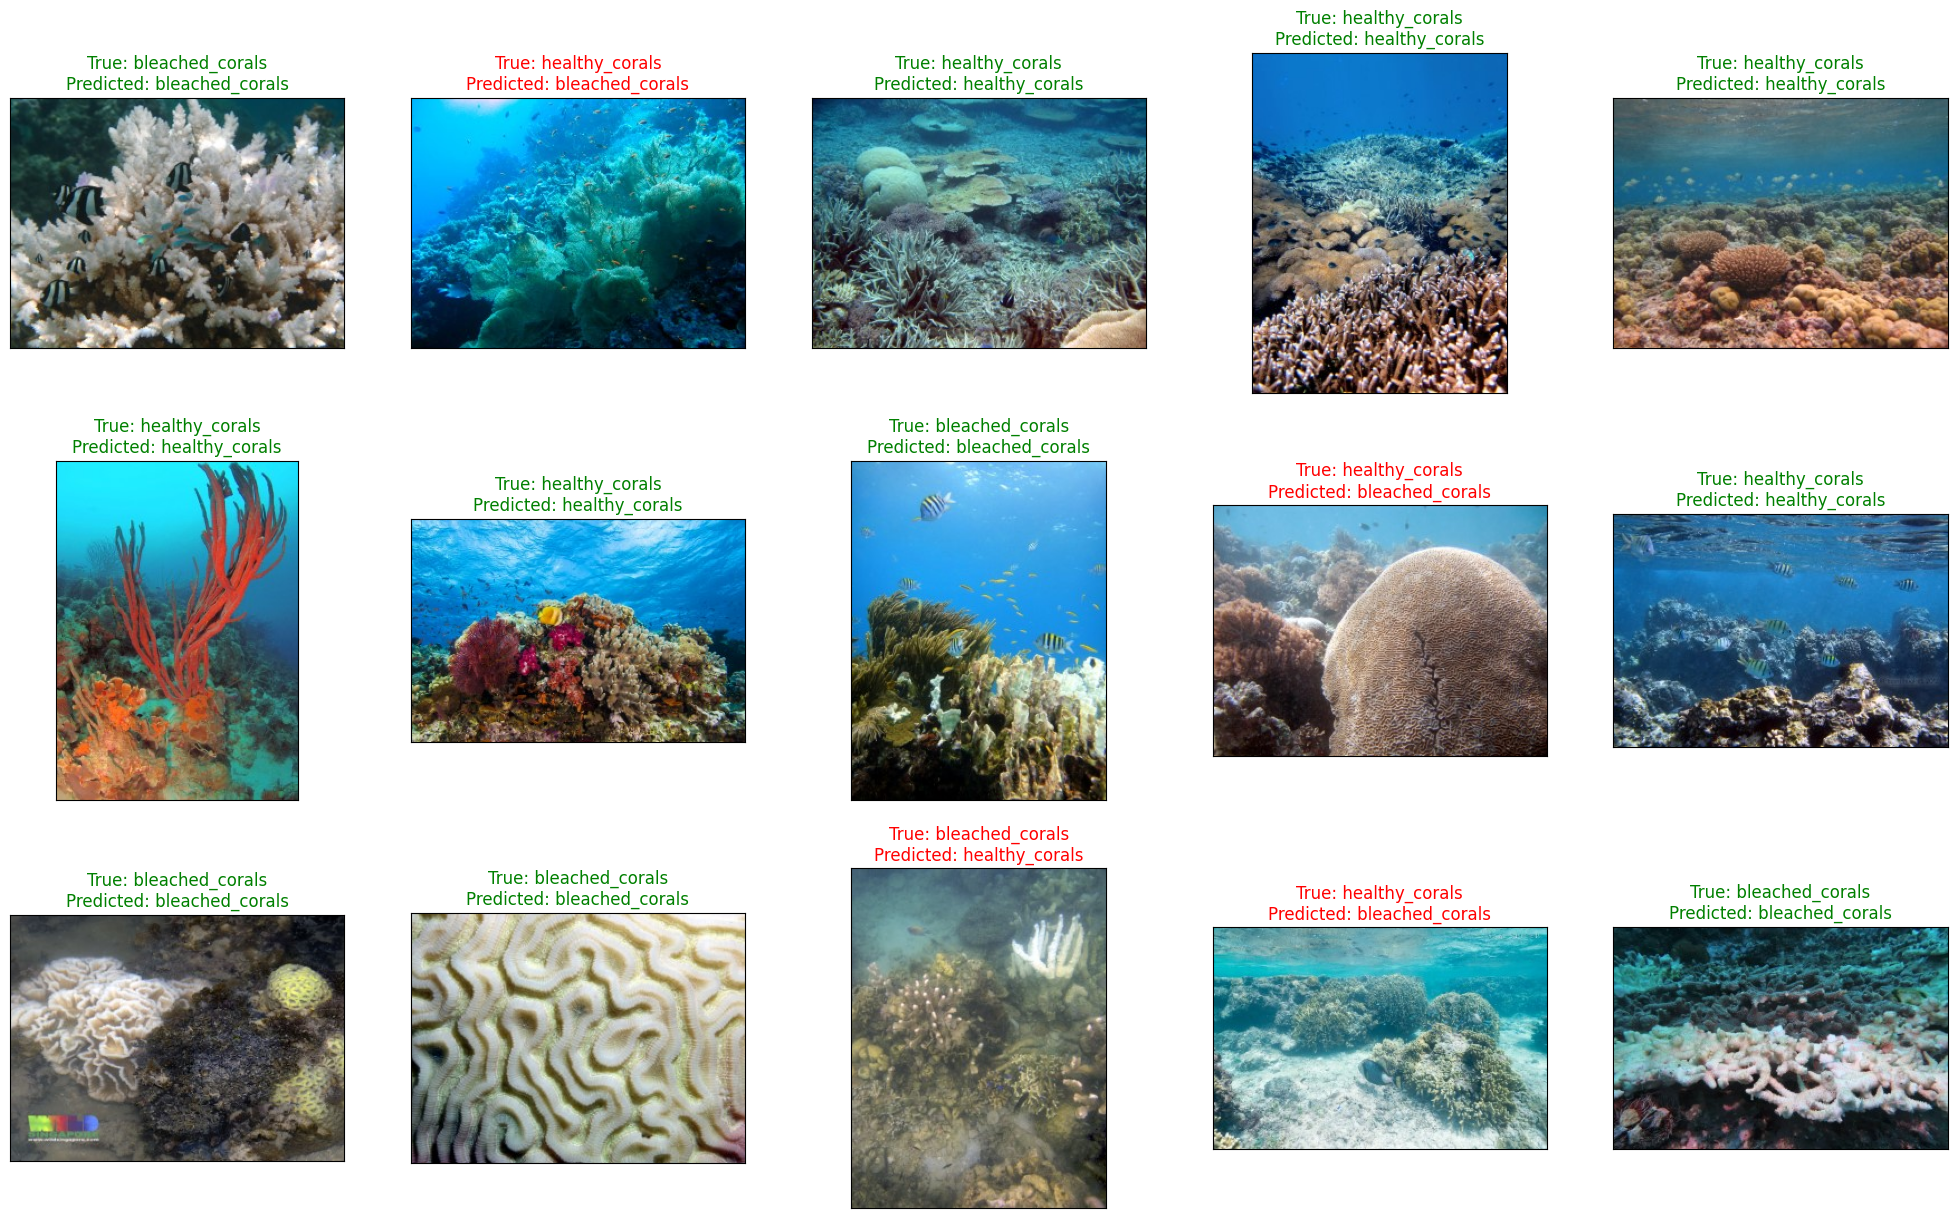

<Figure size 640x480 with 0 Axes>

In [43]:
  # Display 15 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

### Now to implement the pretrained model

In [44]:
# Load the pretained model
pretrained_model = tf.keras.applications.vgg19.VGG19(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

80134624/80134624 [==============================] - 1s 0us/step


In [45]:
# Create checkpoint callback
checkpoint_path = "corals_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for multiple epochs in a row, stop training

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-10)

#### We will now compile and train our pretrained VGG19 model and adjust the hyperparameters if needed.

In [46]:

inputs = pretrained_model.input
x = augment(inputs)
x = Dense(128, activation='relu')(pretrained_model.output)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)


outputs = Dense(2, activation='softmax')(x)

model2 = Model(inputs=inputs, outputs=outputs)

model2.compile(
    optimizer=Adam(0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history2 = model2.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs",
                                    "corals_classification"),
        checkpoint_callback,
        reduce_lr
    ]
)

Saving TensorBoard log files to: training_logs/corals_classification/20231201-005935
Epoch 1/100
19/19 [==============================] - 17s 487ms/step - loss: 1.1399 - accuracy: 0.6034 - val_loss: 2.5410 - val_accuracy: 0.5442 - lr: 0.0010
Epoch 2/100
19/19 [==============================] - 4s 228ms/step - loss: 0.7420 - accuracy: 0.7085 - val_loss: 1.4708 - val_accuracy: 0.5918 - lr: 0.0010
Epoch 3/100
19/19 [==============================] - 4s 219ms/step - loss: 0.7009 - accuracy: 0.7186 - val_loss: 0.9087 - val_accuracy: 0.6531 - lr: 0.0010
Epoch 4/100
19/19 [==============================] - 4s 231ms/step - loss: 0.5873 - accuracy: 0.7441 - val_loss: 1.0052 - val_accuracy: 0.6463 - lr: 0.0010
Epoch 5/100
19/19 [==============================] - 5s 248ms/step - loss: 0.4892 - accuracy: 0.7797 - val_loss: 0.7217 - val_accuracy: 0.7075 - lr: 0.0010
Epoch 6/100
19/19 [==============================] - 4s 220ms/step - loss: 0.4617 - accuracy: 0.7932 - val_loss: 0.5777 - val_accuracy

In [47]:
# Evaluate the model with the test dataset.

results = model2.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.53977
Test Accuracy: 76.76%


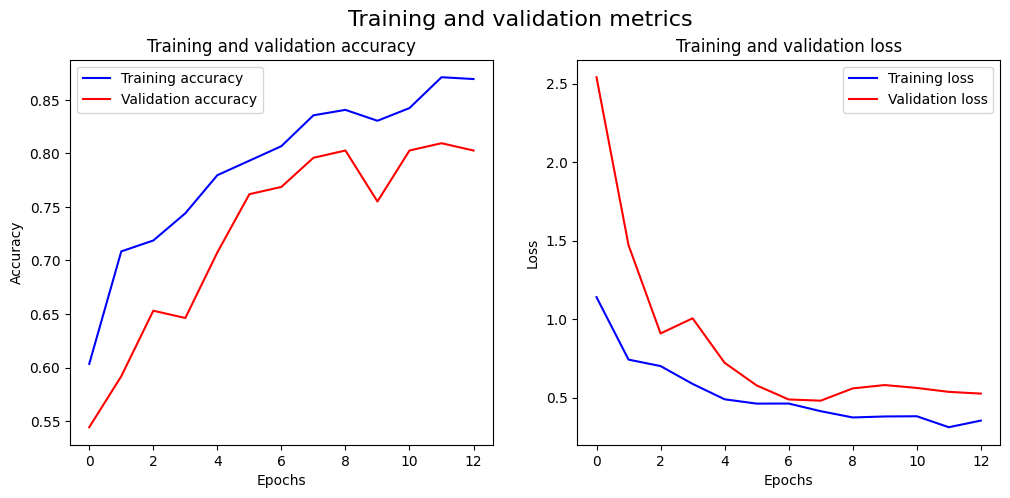

In [48]:
# Plot the training run to visualize the model
accuracy = history2.history['accuracy']
val_accuracy = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(accuracy))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(epochs, accuracy, 'b', label='Training accuracy')
ax1.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
ax1.set_title('Training and validation accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(epochs, loss, 'b', label='Training loss')
ax2.plot(epochs, val_loss, 'r', label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

fig.suptitle('Training and validation metrics', fontsize=16)
plt.show()

In [49]:
# Predict the label of the test_images
pred = model2.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

6/6 [==============================] - 1s 151ms/step
The first 5 predictions: ['healthy_corals', 'healthy_corals', 'healthy_corals', 'healthy_corals', 'healthy_corals']


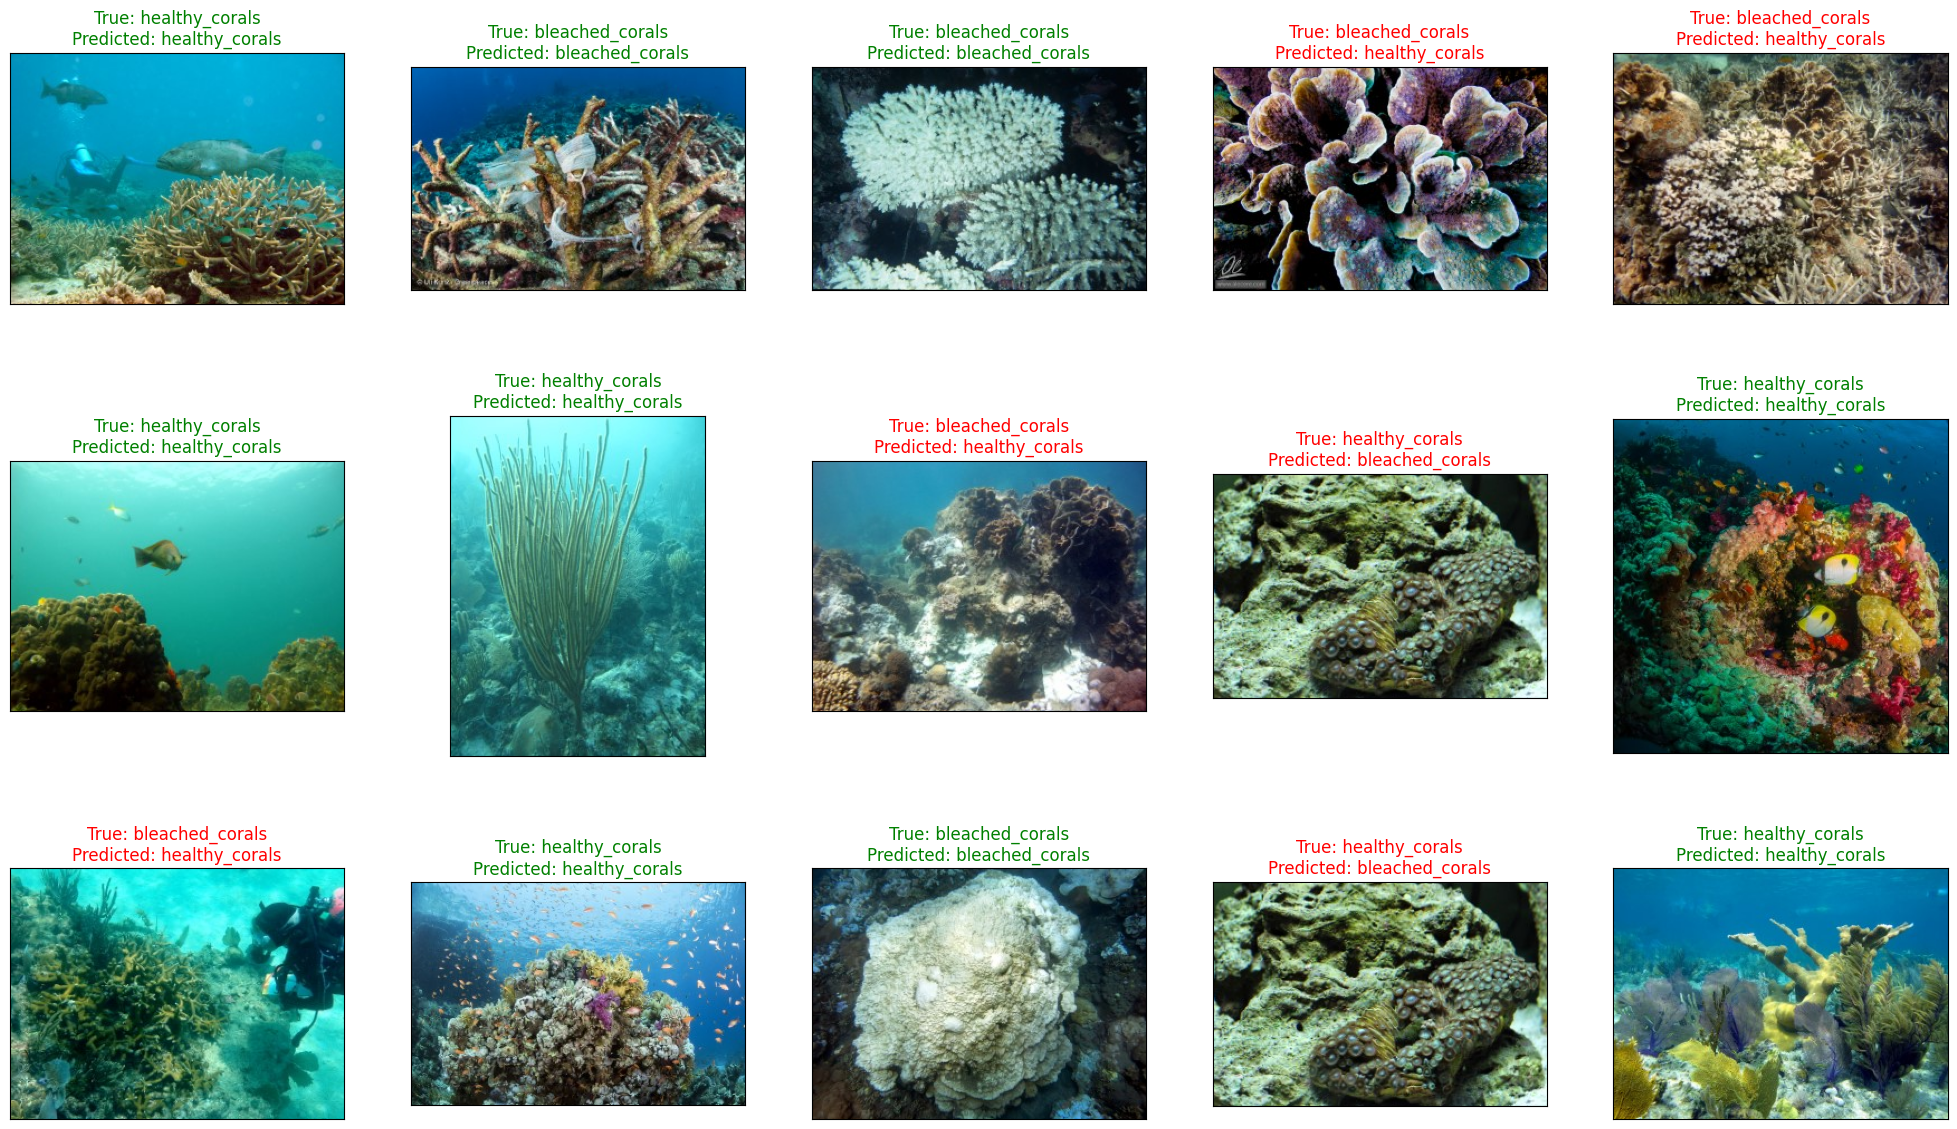

<Figure size 640x480 with 0 Axes>

In [50]:
  # Display 15 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

### Conclusion

In the end, I was able to create a CNN to classify the bleached vs healthy corals with an accuracy of ~ 68% which is not too bad and could be used to classify the images. The VGG19 model was able to get higher accuracy results at ~ 78%. This is a significantly better result and could potentially be used to classify coral images. This could aid scientists in going through large amounts of photos to check the extent of coral degredation. I feel that this sort of application has the potential to make a big change in how we understand coral bleaching. I hope that going forward Artificial intelligence like this will continue to be used for good reasons such as this.

#### Here is the layout of the VGG19 model for reference
ans =
  47x1 Layer array with layers:

     1   'input'     Image Input             224x224x3 images with 'zerocenter' normalization
     2   'conv1_1'   Convolution             64 3x3x3 convolutions with stride [1  1] and padding [1  1  1  1]
     3   'relu1_1'   ReLU                    ReLU
     4   'conv1_2'   Convolution             64 3x3x64 convolutions with stride [1  1] and padding [1  1  1  1]
     5   'relu1_2'   ReLU                    ReLU
     6   'pool1'     Max Pooling             2x2 max pooling with stride [2  2] and padding [0  0  0  0]
     7   'conv2_1'   Convolution             128 3x3x64 convolutions with stride [1  1] and padding [1  1  1  1]
     8   'relu2_1'   ReLU                    ReLU
     9   'conv2_2'   Convolution             128 3x3x128 convolutions with stride [1  1] and padding [1  1  1  1]
    10   'relu2_2'   ReLU                    ReLU
    11   'pool2'     Max Pooling             2x2 max pooling with stride [2  2] and padding [0  0  0  0]
    12   'conv3_1'   Convolution             256 3x3x128 convolutions with stride [1  1] and padding [1  1  1  1]
    13   'relu3_1'   ReLU                    ReLU
    14   'conv3_2'   Convolution             256 3x3x256 convolutions with stride [1  1] and padding [1  1  1  1]
    15   'relu3_2'   ReLU                    ReLU
    16   'conv3_3'   Convolution             256 3x3x256 convolutions with stride [1  1] and padding [1  1  1  1]
    17   'relu3_3'   ReLU                    ReLU
    18   'conv3_4'   Convolution             256 3x3x256 convolutions with stride [1  1] and padding [1  1  1  1]
    19   'relu3_4'   ReLU                    ReLU
    20   'pool3'     Max Pooling             2x2 max pooling with stride [2  2] and padding [0  0  0  0]
    21   'conv4_1'   Convolution             512 3x3x256 convolutions with stride [1  1] and padding [1  1  1  1]
    22   'relu4_1'   ReLU                    ReLU
    23   'conv4_2'   Convolution             512 3x3x512 convolutions with stride [1  1] and padding [1  1  1  1]
    24   'relu4_2'   ReLU                    ReLU
    25   'conv4_3'   Convolution             512 3x3x512 convolutions with stride [1  1] and padding [1  1  1  1]
    26   'relu4_3'   ReLU                    ReLU
    27   'conv4_4'   Convolution             512 3x3x512 convolutions with stride [1  1] and padding [1  1  1  1]
    28   'relu4_4'   ReLU                    ReLU
    29   'pool4'     Max Pooling             2x2 max pooling with stride [2  2] and padding [0  0  0  0]
    30   'conv5_1'   Convolution             512 3x3x512 convolutions with stride [1  1] and padding [1  1  1  1]
    31   'relu5_1'   ReLU                    ReLU
    32   'conv5_2'   Convolution             512 3x3x512 convolutions with stride [1  1] and padding [1  1  1  1]
    33   'relu5_2'   ReLU                    ReLU
    34   'conv5_3'   Convolution             512 3x3x512 convolutions with stride [1  1] and padding [1  1  1  1]
    35   'relu5_3'   ReLU                    ReLU
    36   'conv5_4'   Convolution             512 3x3x512 convolutions with stride [1  1] and padding [1  1  1  1]
    37   'relu5_4'   ReLU                    ReLU
    38   'pool5'     Max Pooling             2x2 max pooling with stride [2  2] and padding [0  0  0  0]
    39   'fc6'       Fully Connected         4096 fully connected layer
    40   'relu6'     ReLU                    ReLU
    41   'drop6'     Dropout                 50% dropout
    42   'fc7'       Fully Connected         4096 fully connected layer
    43   'relu7'     ReLU                    ReLU
    44   'drop7'     Dropout                 50% dropout
    45   'fc8'       Fully Connected         1000 fully connected layer
    46   'prob'      Softmax                 softmax
    47   'output'    Classification Output   crossentropyex with 'tench' and 999 other classes